In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/7k-books-with-metadata/books.csv


# 1. Data Preperation

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
books=pd.read_csv("/kaggle/input/7k-books-with-metadata/books.csv")

In [4]:
books

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0
6806,9788185944609,8185944601,Secrets Of The Heart,NaN,Khalil Gibran,Mysticism,http://books.google.com/books/content?id=XcrVp...,NaN,1993.0,4.08,74.0,324.0
6807,9788445074879,8445074873,Fahrenheit 451,NaN,Ray Bradbury,Book burning,NaN,NaN,2004.0,3.98,186.0,5733.0
6808,9789027712059,9027712050,The Berlin Phenomenology,NaN,Georg Wilhelm Friedrich Hegel,History,http://books.google.com/books/content?id=Vy7Sk...,Since the three volume edition ofHegel's Philo...,1981.0,0.00,210.0,0.0


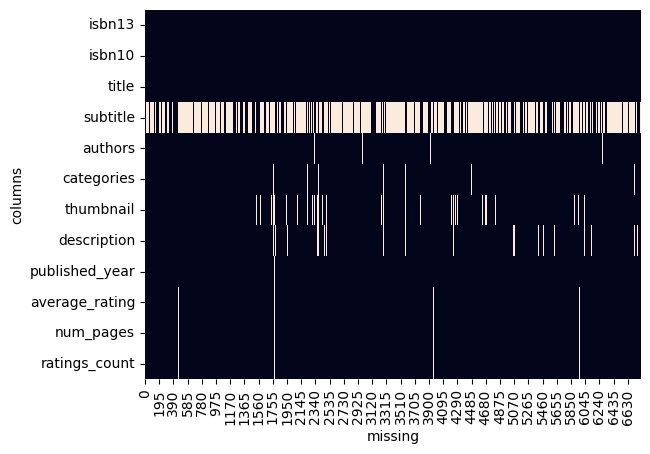

In [5]:
ax=plt.axes()
sns.heatmap(books.isna().transpose(),cbar=False,ax=ax)
plt.xlabel("missing")
plt.ylabel("columns")
plt.show()

we found that subtitles has many missing values but books without subtitles will not affect on our recommender system as it is possible to have books without subtitles but the 4 important features that have high impact on book recommendation are description, published_year, average_rating, num_pages because if the book has missing description so it will have missing published_year, num pages and average rating 
so we will make a corr matrix between the missing in description and the other 3 columns to know if this missing is large or small (to make a decision about imputing or removing)

In [6]:
books['missing_description']=np.where(books['description'].isna(),1,0)
# books["age_of_book"]=2025-books['published_year']

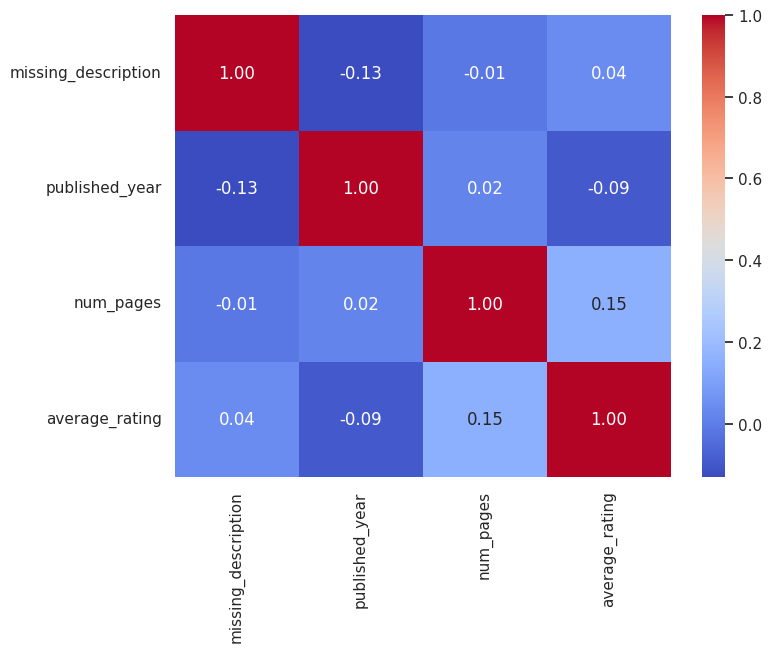

In [7]:
columns_of_interest=['missing_description',"published_year","num_pages","average_rating"]
corr_matrix=books[columns_of_interest].corr(method="spearman")# choose spearman as the columns of interest are binary not continous
sns.set_theme(style="white")
plt.figure(figsize=(8,6))
heatmap=sns.heatmap(corr_matrix,annot=True,fmt=".2f",cmap="coolwarm")
plt.show()

as we see in corr matrix we found that the corr between the missing descriptions have very small corr this means that the missing description is not related to the missings in other columns and it is called MCAR(Missing Completely At Random) so we can treat the missing description seperatly without worrying about bias
we have to check how many missing rows are in the 4 features if those have a very small percenatage from our data size 6810 so it is safe to delete them if not so we have to impute them

In [8]:
books[(books["description"].isna())|
(books["published_year"].isna())|
(books["num_pages"].isna())|
(books["average_rating"].isna())]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description
37,9780006906018,000690601X,The Princess of the Chalet School,NaN,Elinor Mary Brent-Dyer,Juvenile Fiction,http://books.google.com/books/content?id=EJcQP...,NaN,2000.0,4.10,159.0,446.0,1
60,9780007127740,000712774X,The illustrated man,NaN,Ray Bradbury,Fiction,http://books.google.com/books/content?id=kePql...,NaN,2002.0,4.14,186.0,56781.0,1
99,9780020442806,0020442807,"The Chronicles of Narnia: Lion, the witch and ...",NaN,Clive Staples Lewis,Fairy tales,NaN,NaN,1978.0,4.26,1425.0,1446.0,1
102,9780023513206,0023513209,Reason in History,A General Introduction to the Philosophy of Hi...,Georg Wilhelm Friedrich Hegel,Philosophy,http://books.google.com/books/content?id=BCvcY...,NaN,1953.0,3.64,95.0,430.0,1
105,9780026995016,0026995018,Spandau,The Secret Diaries,Albert Speer,History,NaN,NaN,1976.0,4.12,463.0,6.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6787,9783464371640,3464371646,About a Boy,NaN,Nick Hornby,NaN,http://books.google.com/books/content?id=PuDYw...,NaN,2002.0,3.80,256.0,155.0,1
6788,9783540292128,3540292128,Enzyme-Catalyzed Synthesis of Polymers,NaN,Shiro Kobayashi;Helmut Ritter;David Kaplan,Science,http://books.google.com/books/content?id=WXOym...,NaN,2006.0,0.00,254.0,0.0,1
6798,9787506435673,7506435675,Good Fight,NaN,Judd Winick;Matthew Clark,Juvenile Fiction,http://books.google.com/books/content?id=xGPZA...,Presents the adventures of a new group of hero...,2007.0,NaN,NaN,NaN,0
6806,9788185944609,8185944601,Secrets Of The Heart,NaN,Khalil Gibran,Mysticism,http://books.google.com/books/content?id=XcrVp...,NaN,1993.0,4.08,74.0,324.0,1


as we see that the missing values are 5% from the data size so we can safely remove them

In [9]:
books_with_no_missing=books[~(books["description"].isna())&
~(books["published_year"].isna())&
~(books["num_pages"].isna())&
~(books["average_rating"].isna())]
books_with_no_missing

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0,0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,0
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,0
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,0
6808,9789027712059,9027712050,The Berlin Phenomenology,NaN,Georg Wilhelm Friedrich Hegel,History,http://books.google.com/books/content?id=Vy7Sk...,Since the three volume edition ofHegel's Philo...,1981.0,0.00,210.0,0.0,0


In [10]:
books_with_no_missing["categories"].value_counts().sort_values(ascending=False)

categories
Fiction                       2523
Juvenile Fiction               534
Biography & Autobiography      391
History                        258
Literary Criticism             164
                              ... 
Electrons                        1
Pigeons                          1
Brothers and sisters             1
Banks and banking, British       1
English poetry                   1
Name: count, Length: 531, dtype: int64

I want to have a meaningfull  descriptions only so any description that is short is not meaningfull 

In [11]:
books_with_no_missing["description_words_count"] = books_with_no_missing["description"].str.split().str.len()

/tmp/ipykernel_36/1740747289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_with_no_missing["description_words_count"] = books_with_no_missing["description"].str.split().str.len()


In [12]:
books_with_no_missing.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,description_words_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,199
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,205
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0,0,14
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,57
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,45


In [13]:
books_with_no_missing=books_with_no_missing[books_with_no_missing["description_words_count"]>=25]
books_with_no_missing

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,description_words_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,199
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,205
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,57
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,45
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6802,9788172235222,8172235224,Mistaken Identity,NaN,Nayantara Sahgal,Indic fiction (English),http://books.google.com/books/content?id=q-tKP...,On A Train Journey Home To North India After L...,2003.0,2.93,324.0,0.0,0,288
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,0,63
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,0,117
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,0,174


In [14]:
books_with_no_missing["title & subtitle"]=(np.where(books_with_no_missing["subtitle"].isna()
                                                    ,books_with_no_missing["title"],
                                                   books_with_no_missing[["title",'subtitle']].astype(str).agg(" ".join,axis=1))
                                          )

/tmp/ipykernel_36/3616855446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_with_no_missing["title & subtitle"]=(np.where(books_with_no_missing["subtitle"].isna()


let's move to subtitles, before we found that there is a many missing values in it so we will replace the nan with the title rows and if there is no null we will join the two columns together

In [15]:
books_with_no_missing

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,description_words_count,title & subtitle
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,199,Gilead
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,205,Spider's Web A Novel
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,57,Rage of angels
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,45,The Four Loves
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,75,The Problem of Pain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6802,9788172235222,8172235224,Mistaken Identity,NaN,Nayantara Sahgal,Indic fiction (English),http://books.google.com/books/content?id=q-tKP...,On A Train Journey Home To North India After L...,2003.0,2.93,324.0,0.0,0,288,Mistaken Identity
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,0,63,Journey to the East
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,0,117,The Monk Who Sold His Ferrari: A Fable About F...
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,0,174,I Am that Talks with Sri Nisargadatta Maharaj


I want to have a unique identifier for each descritption to use this in vector database so i will make a tagged descriotion column that join the isbn number (isbn10 or 13) and description

In [16]:
books_with_no_missing["tagged_description"]=books_with_no_missing[["isbn13","description"]].astype(str).agg(" ".join,axis=1)
books_with_no_missing

/tmp/ipykernel_36/2710275347.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_with_no_missing["tagged_description"]=books_with_no_missing[["isbn13","description"]].astype(str).agg(" ".join,axis=1)


,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,description_words_count,title & subtitle,tagged_description
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,199,Gilead,9780002005883 A NOVEL THAT READERS and critics...
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,205,Spider's Web A Novel,9780002261982 A new 'Christie for Christmas' -...
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,57,Rage of angels,"9780006178736 A memorable, mesmerizing heroine..."
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,45,The Four Loves,9780006280897 Lewis' work on the nature of lov...
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,75,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6802,9788172235222,8172235224,Mistaken Identity,NaN,Nayantara Sahgal,Indic fiction (English),http://books.google.com/books/content?id=q-tKP...,On A Train Journey Home To North India After L...,2003.0,2.93,324.0,0.0,0,288,Mistaken Identity,9788172235222 On A Train Journey Home To North...
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,0,63,Journey to the East,9788173031014 This book tells the tale of a ma...
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,0,117,The Monk Who Sold His Ferrari: A Fable About F...,9788179921623 Wisdom to Create a Life of Passi...
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,0,174,I Am that Talks with Sri Nisargadatta Maharaj,9788185300535 This collection of the timeless ...


In [17]:
(
    books_with_no_missing.drop(["missing_description","subtitle","description_words_count"],axis=1).to_csv("books_cleaned",index=False)
)

# 2. Vector Database

In [18]:
!pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.66
    Uninstalling langchain-core-0.3.66:
      Successfully uninstalled langchain-core-0.3.66
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.8
    Uninstalling langchain-text-splitters-0.3.8:
      Successfully uninstalled langchain-text-splitters-0.3.8
  Attempting uninstall: l

In [19]:
!pip install langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.4/948.4 kB 21.6 MB/s eta 0:00:0000:01
  Attempting uninstall: openai
    Found existing installation: openai 1.91.0
    Uninstalling openai-1.91.0:
      Successfully uninstalled openai-1.91.0


In [20]:
!pip install langchain_chroma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 82.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 52.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 81.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.9/131.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.0/208.0 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [21]:
from langchain_community.document_loaders import TextLoader # this convert the raw of text into langchain format
from langchain_text_splitters import CharacterTextSplitter # split the texts into chunks
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma # open source vector database

In [22]:
books=pd.read_csv("books_cleaned")
books.head()

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title & subtitle,tagged_description
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead,9780002005883 A NOVEL THAT READERS and critics...
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,Spider's Web A Novel,9780002261982 A new 'Christie for Christmas' -...
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Rage of angels,"9780006178736 A memorable, mesmerizing heroine..."
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,The Four Loves,9780006280897 Lewis' work on the nature of lov...
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le..."


convert tagged_descriptions from DataFrame to text file because langchain is not working with pandas

In [23]:
books["tagged_description"].to_csv("tagged_description.txt",sep="\n",index=False,header=False)

In [24]:
raw_doc=TextLoader("tagged_description.txt").load()
text_splitter=CharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    separator="\n"
)

documents=text_splitter.split_documents(raw_doc)

In [25]:
documents[0]

Document(metadata={'source': 'tagged_description.txt'}, page_content='9780002005883 A NOVEL THAT READERS and critics have been eagerly anticipating for over a decade, Gilead is an astonishingly imagined story of remarkable lives. John Ames is a preacher, the son of a preacher and the grandson (both maternal and paternal) of preachers. It’s 1956 in Gilead, Iowa, towards the end of the Reverend Ames’s life, and he is absorbed in recording his family’s story, a legacy for the young son he will never see grow up. Haunted by his grandfather’s presence, John tells of the rift between his grandfather and his father: the elder, an angry visionary who fought for the abolitionist cause, and his son, an ardent pacifist. He is troubled, too, by his prodigal namesake, Jack (John Ames) Boughton, his best friend’s lost son who returns to Gilead searching for forgiveness and redemption. Told in John Ames’s joyous, rambling voice that finds beauty, humour and truth in the smallest of life’s details, Gi

now i want to create vector database that have the documents and the embedding so we will use Chroma

In [26]:
!pip install langchain_huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.4/563.4 kB 10.6 MB/s eta 0:00:0000:01
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.33.1
    Uninstalling huggingface-hub-0.33.1:
      Successfully uninstalled huggingface-hub-0.33.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.5.1 which is incompatible.


In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

2025-09-21 16:51:29.602700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758473489.948035      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758473490.052115      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [28]:
dp_books=Chroma.from_documents(documents,embeddings)

In [29]:
query="A book to teach childern about nature"
docs=dp_books.similarity_search(query,k=10)
docs

[Document(id='33254a6e-ed4b-49b3-a084-996114ec8d54', metadata={'source': 'tagged_description.txt'}, page_content="9780786808069 Children will discover the exciting world of their own backyard in this introduction to familiar animals from cats and dogs to bugs and frogs. The combination of photographs, illustrations, and fun facts make this an accessible and delightful learning experience.\n9780786808373 Introducing your baby to birds, cats, dogs, and babies through fine art, illsutration and photographs. These books are a rare opportunity to expose little ones to a range of images on a single subject, from simple child's drawings and abstract art to playful photos. A brief text accompanies each image, introducing baby to some basic -- and sometimes playful -- information on the subjects."),
 Document(id='de34fb14-afbd-433f-80ca-263a802982ba', metadata={'source': 'tagged_description.txt'}, page_content="9780786808380 Introduce your babies to birds, cats, dogs, and babies through fine ar

In [30]:
books[books["isbn13"]== int(docs[0].page_content.split()[0].strip())]

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title & subtitle,tagged_description
3747,9780786808069,0786808063,Baby Einstein: Neighborhood Animals,Marilyn Singer;Julie Aigner-Clark,Juvenile Fiction,http://books.google.com/books/content?id=X9a4P...,Children will discover the exciting world of t...,2001.0,3.89,16.0,180.0,Baby Einstein: Neighborhood Animals,9780786808069 Children will discover the excit...


In [ ]:
import re

def retrieve_recommendations(query, k=10) -> pd.DataFrame:
    books_list = []
    docs = dp_books.similarity_search(query, k=50)
    
    for i in range(len(docs)):
        raw_isbn = docs[i].page_content.strip('""').split()[0]
        clean_isbn = re.sub(r"\D", "", raw_isbn)   # remove any non-digit characters
        books_list.append(clean_isbn)
    
    results = books[books["isbn13"].astype(str).isin(books_list)]
    
    return results.head(k)

query="A book to teach childern about nature"
retrieve_recommendations(query)

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title & subtitle,tagged_description
30,9780006646006,000664600X,Ocean Star Express,Mark Haddon;Peter Sutton,Juvenile Fiction,http://books.google.com/books/content?id=I2QZA...,Joe and his parents are enjoying a summer holi...,2002.0,3.50,32.0,1.0,Ocean Star Express,9780006646006 Joe and his parents are enjoying...
59,9780007151240,0007151241,The Family Way,Tony Parsons,Parenthood,http://books.google.com/books/content?id=dJEIx...,It should be the most natural thing in the wor...,2005.0,3.51,400.0,2095.0,The Family Way,9780007151240 It should be the most natural th...
368,9780061127762,0061127760,Charlotte's Web Signature Edition,E. B. White,Juvenile Fiction,http://books.google.com/books/content?id=oi9BP...,This is the story of a little girl named Fern ...,2006.0,4.16,224.0,226.0,Charlotte's Web Signature Edition,9780061127762 This is the story of a little gi...
383,9780061144899,0061144894,When the Heart Waits,Sue Monk Kidd,Religion,http://books.google.com/books/content?id=JlP91...,From the Bestselling Author of The Secret Life...,2006.0,4.17,240.0,2141.0,When the Heart Waits Spiritual Direction for L...,9780061144899 From the Bestselling Author of T...
404,9780064402453,0064402452,Racso and the Rats of NIMH,Jane Leslie Conly,Juvenile Fiction,http://books.google.com/books/content?id=MgoNv...,"‘Racso, a brash and boastful little rodent, is...",1988.0,3.76,288.0,3231.0,Racso and the Rats of NIMH,"9780064402453 ‘Racso, a brash and boastful lit..."
406,9780064403870,0064403874,"R-T, Margaret, and the Rats of NIMH",Jane Leslie Conly,Juvenile Fiction,http://books.google.com/books/content?id=WTHHH...,"When Margaret and her younger brother, Artie, ...",1991.0,3.52,272.0,631.0,"R-T, Margaret, and the Rats of NIMH",9780064403870 When Margaret and her younger br...
407,9780064404419,0064404412,The Rainbow People,Laurence Yep,Juvenile Fiction,http://books.google.com/books/content?id=5AHwq...,"""Culled from 69 stories collected in a [1930s]...",1992.0,3.75,208.0,202.0,The Rainbow People,"9780064404419 ""Culled from 69 stories collecte..."
416,9780064406925,006440692X,Winter on the Farm,Laura Ingalls Wilder,Juvenile Fiction,http://books.google.com/books/content?id=IvlKH...,The Little House books tell the story of a lit...,1997.0,4.13,32.0,400.0,Winter on the Farm,9780064406925 The Little House books tell the ...
427,9780064434874,0064434877,Christmas in the Big Woods,Laura Ingalls Wilder,Juvenile Fiction,http://books.google.com/books/content?id=FT1Yp...,"Long ago, a little girl named Laura Ingalls li...",1997.0,4.19,32.0,2062.0,Christmas in the Big Woods,"9780064434874 Long ago, a little girl named La..."
428,9780064434942,006443494X,A Little House Birthday,Laura Ingalls Wilder,Juvenile Fiction,http://books.google.com/books/content?id=fyfDR...,Join the Ingalls family as they celebrate litt...,1998.0,4.13,40.0,444.0,A Little House Birthday,9780064434942 Join the Ingalls family as they ...


# 3. Zero-Shot classification using LLMs

In [32]:
books["categories"].value_counts().reset_index()

,categories,count
0,Fiction,2111
1,Juvenile Fiction,390
2,Biography & Autobiography,311
3,History,207
4,Literary Criticism,124
...,...,...
474,Human-animal relationships,1
475,Imperialism,1
476,Aged women,1
477,Humorous stories,1


mapping the highest freq books categories into 3 classes ==> Fiction , Nonfiction, Children's Fiction and Children's Nonfiction

In [33]:
category_mapping = {'Fiction' : "Fiction",
 'Juvenile Fiction': "Children's Fiction",
 'Biography & Autobiography': "Nonfiction",
 'History': "Nonfiction",
 'Literary Criticism': "Nonfiction",
 'Philosophy': "Nonfiction",
 'Religion': "Nonfiction",
 'Comics & Graphic Novels': "Fiction",
 'Drama': "Fiction",
 'Juvenile Nonfiction': "Children's Nonfiction",
 'Science': "Nonfiction",
 'Poetry': "Fiction"}

books["simple_categories"] = books["categories"].map(category_mapping)

remove any null categories in the new column simple categories 

In [34]:
books[~(books["simple_categories"].isna())]

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title & subtitle,tagged_description,simple_categories
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead,9780002005883 A NOVEL THAT READERS and critics...,Fiction
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Rage of angels,"9780006178736 A memorable, mesmerizing heroine...",Fiction
8,9780006482079,0006482074,Warhost of Vastmark,Janny Wurts,Fiction,http://books.google.com/books/content?id=uOL0f...,"Tricked once more by his wily half-brother, Ly...",1995.0,4.03,522.0,2966.0,Warhost of Vastmark,9780006482079 Tricked once more by his wily ha...,Fiction
30,9780006646006,000664600X,Ocean Star Express,Mark Haddon;Peter Sutton,Juvenile Fiction,http://books.google.com/books/content?id=I2QZA...,Joe and his parents are enjoying a summer holi...,2002.0,3.50,32.0,1.0,Ocean Star Express,9780006646006 Joe and his parents are enjoying...,Children's Fiction
46,9780007121014,0007121016,Taken at the Flood,Agatha Christie,Fiction,http://books.google.com/books/content?id=3gWlx...,A Few Weeks After Marrying An Attractive Young...,2002.0,3.71,352.0,8852.0,Taken at the Flood,9780007121014 A Few Weeks After Marrying An At...,Fiction
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5178,9781933648279,1933648279,Night Has a Thousand Eyes,Cornell Woolrich,Fiction,http://books.google.com/books/content?id=3Gk6s...,"""Cornell Woolrich's novels define the essence ...",2007.0,3.77,344.0,680.0,Night Has a Thousand Eyes,"9781933648279 ""Cornell Woolrich's novels defin...",Fiction
5188,9784770028969,4770028962,Coin Locker Babies,村上龍,Fiction,http://books.google.com/books/content?id=87DJw...,Rescued from the lockers in which they were le...,2002.0,3.75,393.0,5560.0,Coin Locker Babies,9784770028969 Rescued from the lockers in whic...,Fiction
5189,9788122200850,8122200850,"Cry, the Peacock",Anita Desai,Fiction,http://books.google.com/books/content?id=_QKwV...,This book is the story of a young girl obsesse...,1980.0,3.22,218.0,134.0,"Cry, the Peacock",9788122200850 This book is the story of a youn...,Fiction
5195,9788185300535,8185300534,I Am that,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,I Am that Talks with Sri Nisargadatta Maharaj,9788185300535 This collection of the timeless ...,Nonfiction


In [ ]:
from huggingface_hub import login

HUGGING_FACE_KEY=""
login(HUGGING_FACE_KEY)

In [36]:
from transformers import pipeline
categories_list=["Fiction","Nonfiction"]
pipe=pipeline("zero-shot-classification",model="facebook/bart-large-mnli",device=0)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [37]:
sequence = books.loc[books["simple_categories"] == "Fiction", "description"].reset_index(drop=True)[0]

In [38]:
pipe(sequence,categories_list)

{'sequence': 'A NOVEL THAT READERS and critics have been eagerly anticipating for over a decade, Gilead is an astonishingly imagined story of remarkable lives. John Ames is a preacher, the son of a preacher and the grandson (both maternal and paternal) of preachers. It’s 1956 in Gilead, Iowa, towards the end of the Reverend Ames’s life, and he is absorbed in recording his family’s story, a legacy for the young son he will never see grow up. Haunted by his grandfather’s presence, John tells of the rift between his grandfather and his father: the elder, an angry visionary who fought for the abolitionist cause, and his son, an ardent pacifist. He is troubled, too, by his prodigal namesake, Jack (John Ames) Boughton, his best friend’s lost son who returns to Gilead searching for forgiveness and redemption. Told in John Ames’s joyous, rambling voice that finds beauty, humour and truth in the smallest of life’s details, Gilead is a song of celebration and acceptance of the best and the worst

In [39]:
def generate_predictions(sequence, categories):
    predictions = pipe(sequence, categories)
    max_index = np.argmax(predictions["scores"])
    max_label = predictions["labels"][max_index]
    return max_label

In [40]:
generate_predictions(sequence,categories_list)

'Fiction'

let's check the model accuarcy by checking how the model performance on predcition fiction books and non fiction books seperatly

In [41]:
from tqdm import tqdm

actual_cats = []
predicted_cats = []

for i in tqdm(range(0, 300)):
    sequence = books.loc[books["simple_categories"] == "Fiction", "description"].reset_index(drop=True)[i]
    predicted_cats += [generate_predictions(sequence, categories_list)]
    actual_cats += ["Fiction"]

100%|██████████| 300/300 [00:23<00:00, 12.61it/s]


In [42]:
for i in tqdm(range(0, 300)):
    sequence = books.loc[books["simple_categories"] == "Nonfiction", "description"].reset_index(drop=True)[i]
    predicted_cats += [generate_predictions(sequence, categories_list)]
    actual_cats += ["Nonfiction"]

100%|██████████| 300/300 [00:26<00:00, 11.48it/s]


In [43]:
predictions_df = pd.DataFrame({"actual_categories": actual_cats, "predicted_categories": predicted_cats})
predictions_df

,actual_categories,predicted_categories
0,Fiction,Fiction
1,Fiction,Fiction
2,Fiction,Fiction
3,Fiction,Nonfiction
4,Fiction,Fiction
...,...,...
595,Nonfiction,Nonfiction
596,Nonfiction,Fiction
597,Nonfiction,Nonfiction
598,Nonfiction,Nonfiction


In [44]:
predictions_df["correct_prediction"] = (
    np.where(predictions_df["actual_categories"] == predictions_df["predicted_categories"], 1, 0)
)

In [45]:
predictions_df["correct_prediction"].sum() / len(predictions_df)

0.7783333333333333

so i have a missing categories that i didn't include it in my categories_list so i will use zero shot classification on them to fill in categories for unknown ones

In [46]:
isbns = []
predicted_cats = []

missing_cats = books.loc[books["simple_categories"].isna(), ["isbn13", "description"]].reset_index(drop=True)

In [47]:
for i in tqdm(range(0, len(missing_cats))):
    sequence = missing_cats["description"][i]
    predicted_cats += [generate_predictions(sequence, categories_list)]
    isbns += [missing_cats["isbn13"][i]]

100%|██████████| 1454/1454 [02:15<00:00, 10.76it/s]


In [48]:
missing_predicted_df = pd.DataFrame({"isbn13": isbns, "predicted_categories": predicted_cats})
missing_predicted_df

,isbn13,predicted_categories
0,9780002261982,Fiction
1,9780006280897,Nonfiction
2,9780006280934,Nonfiction
3,9780006380832,Nonfiction
4,9780006470229,Fiction
...,...,...
1449,9788125026600,Nonfiction
1450,9788171565641,Fiction
1451,9788172235222,Fiction
1452,9788173031014,Nonfiction


In [49]:
books = pd.merge(books, missing_predicted_df, on="isbn13", how="left")
books["simple_categories"] = np.where(books["simple_categories"].isna(), books["predicted_categories"], books["simple_categories"])
books = books.drop(columns = ["predicted_categories"])

In [50]:
books.to_csv("books_with_categories.csv", index=False)

# 4. Sentiment Analysis using LLMs

In [51]:
books=pd.read_csv("books_with_categories.csv")

In [54]:
classifier=pipeline("text-classification",model="j-hartmann/emotion-english-distilroberta-base",top_k=None)
classifier("I love you")

Device set to use cuda:0


[[{'label': 'joy', 'score': 0.9687248468399048},
  {'label': 'sadness', 'score': 0.016927115619182587},
  {'label': 'neutral', 'score': 0.005502504296600819},
  {'label': 'surprise', 'score': 0.004897598177194595},
  {'label': 'anger', 'score': 0.0022066100500524044},
  {'label': 'disgust', 'score': 0.0011457920772954822},
  {'label': 'fear', 'score': 0.0005955384694971144}]]

In [56]:
books["description"][0]

'A NOVEL THAT READERS and critics have been eagerly anticipating for over a decade, Gilead is an astonishingly imagined story of remarkable lives. John Ames is a preacher, the son of a preacher and the grandson (both maternal and paternal) of preachers. It’s 1956 in Gilead, Iowa, towards the end of the Reverend Ames’s life, and he is absorbed in recording his family’s story, a legacy for the young son he will never see grow up. Haunted by his grandfather’s presence, John tells of the rift between his grandfather and his father: the elder, an angry visionary who fought for the abolitionist cause, and his son, an ardent pacifist. He is troubled, too, by his prodigal namesake, Jack (John Ames) Boughton, his best friend’s lost son who returns to Gilead searching for forgiveness and redemption. Told in John Ames’s joyous, rambling voice that finds beauty, humour and truth in the smallest of life’s details, Gilead is a song of celebration and acceptance of the best and the worst the world ha

In [55]:
classifier(books["description"][0])

[[{'label': 'fear', 'score': 0.6548413038253784},
  {'label': 'neutral', 'score': 0.16985206305980682},
  {'label': 'sadness', 'score': 0.11640888452529907},
  {'label': 'surprise', 'score': 0.020700626075267792},
  {'label': 'disgust', 'score': 0.019100703299045563},
  {'label': 'joy', 'score': 0.015161297284066677},
  {'label': 'anger', 'score': 0.003935146611183882}]]

I will apply sentitment analysis on each sentence in the description so in the first description it has many senetence so i will make this on every senetence that's because each sentence might has different emotions

In [57]:
classifier(books["description"][0].split("."))

[[{'label': 'surprise', 'score': 0.7296026945114136},
  {'label': 'neutral', 'score': 0.1403856873512268},
  {'label': 'fear', 'score': 0.06816220283508301},
  {'label': 'joy', 'score': 0.04794241115450859},
  {'label': 'anger', 'score': 0.009156348183751106},
  {'label': 'disgust', 'score': 0.00262847519479692},
  {'label': 'sadness', 'score': 0.0021221605129539967}],
 [{'label': 'neutral', 'score': 0.44937071204185486},
  {'label': 'disgust', 'score': 0.2735914885997772},
  {'label': 'joy', 'score': 0.10908304899930954},
  {'label': 'sadness', 'score': 0.09362724423408508},
  {'label': 'anger', 'score': 0.040478333830833435},
  {'label': 'surprise', 'score': 0.026970181614160538},
  {'label': 'fear', 'score': 0.006879060063511133}],
 [{'label': 'neutral', 'score': 0.6462162137031555},
  {'label': 'sadness', 'score': 0.2427332103252411},
  {'label': 'disgust', 'score': 0.04342261329293251},
  {'label': 'surprise', 'score': 0.028300540521740913},
  {'label': 'joy', 'score': 0.014211442

so we will take the highest sentence emtion prob and this is will be the emotion of the book description

In [58]:
emotion_labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]
isbn = []
emotion_scores = {label: [] for label in emotion_labels}

def calculate_max_emotion_scores(predictions):
    per_emotion_scores = {label: [] for label in emotion_labels}
    for prediction in predictions:
        sorted_predictions = sorted(prediction, key=lambda x: x["label"])
        for index, label in enumerate(emotion_labels):
            per_emotion_scores[label].append(sorted_predictions[index]["score"])
    return {label: np.max(scores) for label, scores in per_emotion_scores.items()}

In [59]:
for i in tqdm(range(len(books))):
    isbn.append(books["isbn13"][i])
    sentences = books["description"][i].split(".")
    predictions = classifier(sentences)
    max_scores = calculate_max_emotion_scores(predictions)
    for label in emotion_labels:
        emotion_scores[label].append(max_scores[label])

100%|██████████| 5197/5197 [02:01<00:00, 42.87it/s]


In [60]:
emotion_df=pd.DataFrame(emotion_scores)
emotion_df["isbn13"]=isbn

In [61]:
emotion_df

,anger,disgust,fear,joy,sadness,surprise,neutral,isbn13
0,0.064134,0.273591,0.928168,0.932797,0.646216,0.967158,0.729603,9780002005883
1,0.612618,0.348284,0.942528,0.704422,0.887939,0.111690,0.252545,9780002261982
2,0.064134,0.104007,0.972321,0.767237,0.549477,0.111690,0.078766,9780006178736
3,0.351484,0.150723,0.360706,0.251881,0.732685,0.111690,0.078766,9780006280897
4,0.081412,0.184495,0.095043,0.040564,0.884390,0.475881,0.078766,9780006280934
...,...,...,...,...,...,...,...,...
5192,0.148208,0.030643,0.919165,0.255170,0.853722,0.980877,0.030656,9788172235222
5193,0.064134,0.114383,0.051363,0.400263,0.883199,0.111690,0.227765,9788173031014
5194,0.009997,0.009929,0.339218,0.947779,0.375755,0.066685,0.057625,9788179921623
5195,0.064134,0.104007,0.459269,0.759455,0.951104,0.368111,0.078766,9788185300535


In [62]:
books=pd.merge(books,emotion_df,on="isbn13")
books

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,...,title & subtitle,tagged_description,simple_categories,anger,disgust,fear,joy,sadness,surprise,neutral
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,...,Gilead,9780002005883 A NOVEL THAT READERS and critics...,Fiction,0.064134,0.273591,0.928168,0.932797,0.646216,0.967158,0.729603
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,...,Spider's Web A Novel,9780002261982 A new 'Christie for Christmas' -...,Fiction,0.612618,0.348284,0.942528,0.704422,0.887939,0.111690,0.252545
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,...,Rage of angels,"9780006178736 A memorable, mesmerizing heroine...",Fiction,0.064134,0.104007,0.972321,0.767237,0.549477,0.111690,0.078766
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,...,The Four Loves,9780006280897 Lewis' work on the nature of lov...,Nonfiction,0.351484,0.150723,0.360706,0.251881,0.732685,0.111690,0.078766
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,...,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le...",Nonfiction,0.081412,0.184495,0.095043,0.040564,0.884390,0.475881,0.078766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5192,9788172235222,8172235224,Mistaken Identity,Nayantara Sahgal,Indic fiction (English),http://books.google.com/books/content?id=q-tKP...,On A Train Journey Home To North India After L...,2003.0,2.93,324.0,...,Mistaken Identity,9788172235222 On A Train Journey Home To North...,Fiction,0.148208,0.030643,0.919165,0.255170,0.853722,0.980877,0.030656
5193,9788173031014,8173031010,Journey to the East,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,...,Journey to the East,9788173031014 This book tells the tale of a ma...,Nonfiction,0.064134,0.114383,0.051363,0.400263,0.883199,0.111690,0.227765
5194,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,...,The Monk Who Sold His Ferrari: A Fable About F...,9788179921623 Wisdom to Create a Life of Passi...,Fiction,0.009997,0.009929,0.339218,0.947779,0.375755,0.066685,0.057625
5195,9788185300535,8185300534,I Am that,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,...,I Am that Talks with Sri Nisargadatta Maharaj,9788185300535 This collection of the timeless ...,Nonfiction,0.064134,0.104007,0.459269,0.759455,0.951104,0.368111,0.078766


In [63]:
books.to_csv("books_with_emotions")

# 5. Gradio Dashboard